In [ ]:
cd("/Users/federicoclaudi/Documents/Github/LocomotionControl/analysis/behavior")
import Pkg; 
Pkg.activate(".")

using Plots
using Term
import Term: install_term_logger
import Term.progress: track as pbar
import MyterialColors: grey_dark, grey, pink, pink_dark
using Colors, CSV, Glob, NaturalSort, Colors
import DataFrames: DataFrame

using jcontrol
using jcontrol.visuals
install_term_logger();
import jcontrol: ξ

### Multi horizons animation

Create an animation of all the "solutions" from the multiple horizons simulations compared to the global solution

In [ ]:
# load trials
trials = load_cached_trials(; keep_n = nothing);
@info "Loaded $(length(trials)) trials"
ntrials = length(trials)

X = getfield.(trials, :x)
Y = getfield.(trials, :y)
nothing

In [ ]:
# load solutions

function fix_solution_dtype(sol)
    # for col in names(sol)
    #     sol[:, col] = map(v-> v isa Number ? v : parse(Float64, v), sol[:, col])
    # end
    sol.Fu = map(v-> v isa Number ? v : parse(Float64, v), sol.Fu)
    sol
end

fixvec(vec) = map(v-> v isa Number ? v : parse(Float64, v), vec)

function df2sol(df)
    _keys = filter!(k -> Symbol(k) != :δt, names(df))
    dt = "δt" ∈ names(df) ? df[1, :δt] : 0.0

    return Solution(; Dict(map(k -> Symbol(k)=>fixvec(df[:, k]), _keys))..., δt=dt)
end


# load MTM global solution
globalsolution = DataFrame(CSV.File(joinpath(PATHS["horizons_sims_cache"], "global_solution.csv")))
globalsolution = Solution(fix_solution_dtype(globalsolution));

# load individual horizons solutions
# load individual solutions
files = sort(glob("multiple_horizons_mtm_horizon_length*.csv", PATHS["horizons_sims_cache"]), lt=natural)

solutions_df = map(file->DataFrame(CSV.File(file)), files)
solutions_df = map(sol -> fix_solution_dtype(sol), solutions_df)

solutions = df2sol.(solutions_df)
_names = map(file -> split(file, "_")[end][1:end-4], files);

colors = range(HSL(326, .9, .68), stop=HSL(212, .9, .6), length=max(2, length(solutions)))



### Make animation

@Info (Plots.#buildanimation#237):  Saved animation to  
  │ 
  │ (String)  ▶  fn = /Users/federicoclaudi/Dropbox (UCL)/Rotation_vte/Writings/THESIS/Chpt3/Videos/multiple_horizons.gif 
  ╰──────────────────────────────────────────────── 
                      Wed, 27 Apr 2022 21:17:28 


Plots.AnimatedGif("/Users/federicoclaudi/Dropbox (UCL)/Rotation_vte/Writings/THESIS/Chpt3/Videos/multiple_horizons.gif")
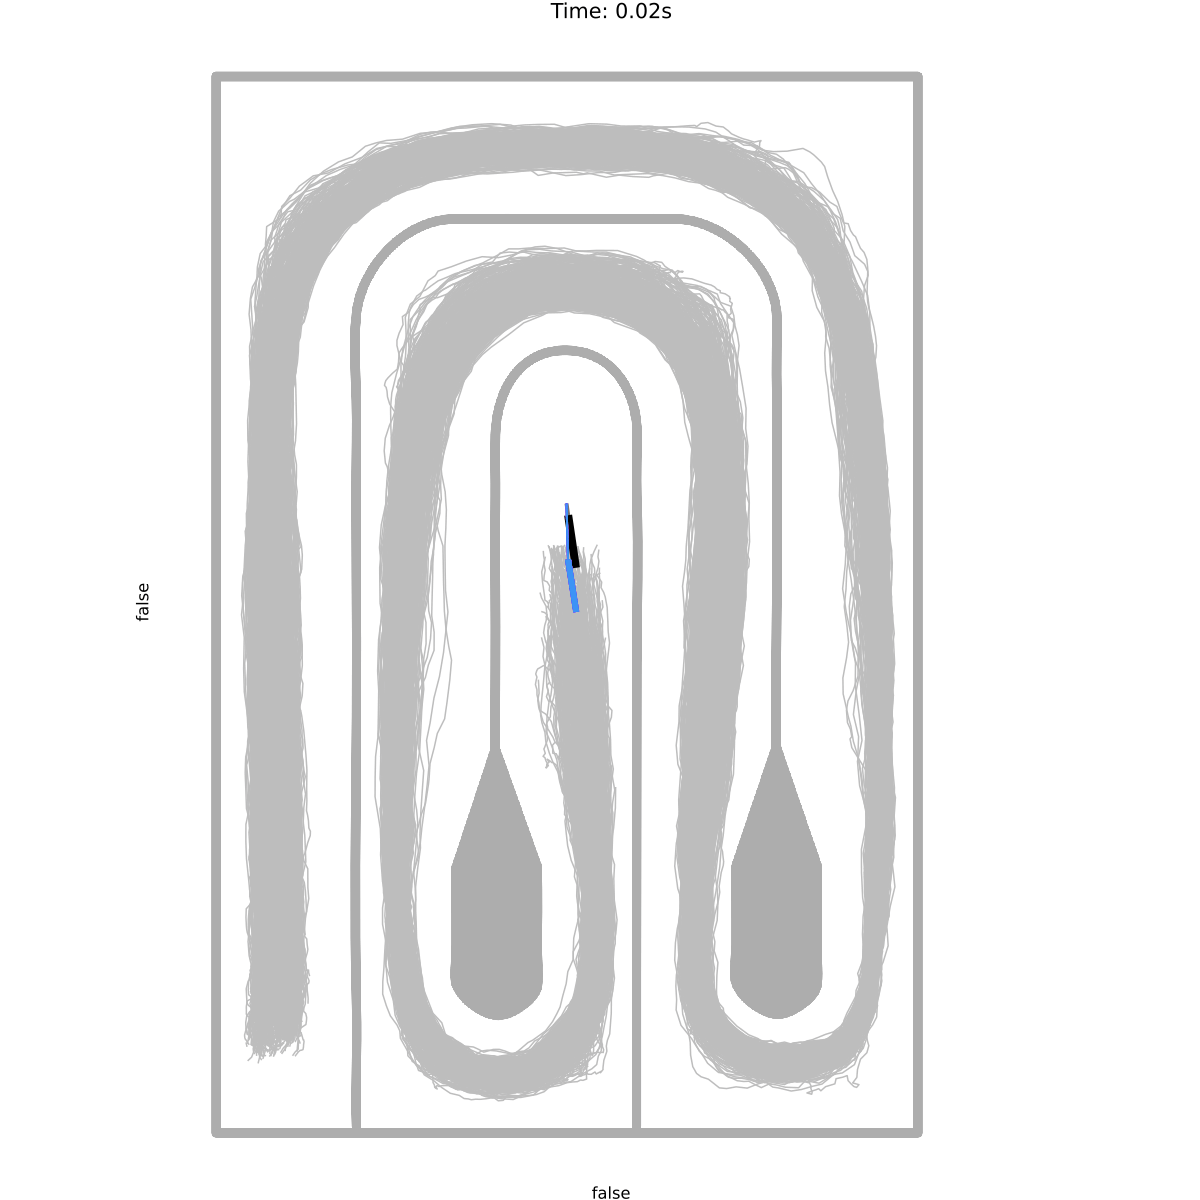

In [23]:
# create plot
l = 1.5
idx(sol, time) = isnothing(findfirst(sol.t .>= time)) ? length(sol.t) : findfirst(sol.t .>= time)


N = length(globalsolution.x)
anim = @animate for i in 1:N
    time = i * 1/60
    time > 5 && continue

    plt = draw(:arena)
    plot!(;xlim=[0, 45], ylim=[0, 60], axis=nothing, xlabel=false, ylabel=false, showaxis = false, title="Time: $(round(i/60; digits=2))s")
    draw!.(trials[1:500])

    # draw the global solution
    _idx = idx(globalsolution, time)
    plot!(globalsolution.x[1:_idx], globalsolution.y[1:_idx], color=grey_dark, lw=4, label=nothing)
    plot!(
        [globalsolution.x[_idx], globalsolution.x[_idx] + l * 2 * cos(globalsolution.θ[_idx])], 
        [globalsolution.y[_idx], globalsolution.y[_idx] + l * 2 * sin(globalsolution.θ[_idx])], 
        color="black", lw=8, label=nothing
    )

    # draw the individual solutions
    for j in 1:length(solutions)
        sol = solutions[j]
        _idx = idx(sol, time)
        plot!(sol.x[1:_idx], sol.y[1:_idx], color=colors[j], lw=2, label=nothing)
        plot!(
            [sol.x[_idx], sol.x[_idx] + l * 2 * cos(sol.θ[_idx])], 
            [sol.y[_idx], sol.y[_idx] + l * 2 * sin(sol.θ[_idx])], 
            color=colors[j], lw=6, label=nothing
        )
    end

end



gifpath = joinpath("/Users/federicoclaudi/Dropbox (UCL)/Rotation_vte/Writings/THESIS/Chpt3/Videos", "multiple_horizons.gif")
mygif = gif(anim, gifpath, fps=60)

In [ ]:
vidpath = joinpath("/Users/federicoclaudi/Dropbox (UCL)/Rotation_vte/Writings/THESIS/Chpt3/Videos", "multiple_horizons.mp4")
mymp4 = mp4(anim, vidpath, fps=60)
nothing